<a href="https://colab.research.google.com/github/divyanshuraj6815/eva/blob/master/Project%201/Assignment_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Conv2D, Input, DepthwiseConv2D, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import layers, models

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

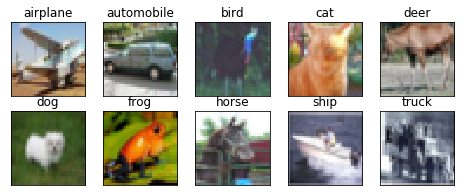

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)
cardinality = 32


In [0]:
#call heavenly Gods
from keras import layers

#define global parameters
img_width = 32
img_height = 32
img_channels = 3
cardinality = 4


def assignment_6B (x):
  
  def add_common_layers (y):
    y = layers.BatchNormalization ()(y)
    y = layers.Dropout (0.1)(y)
    return y
  
  def grouped_convolution (y, no_of_channels, strides, dilation = 1):
    
    assert not no_of_channels % cardinality
    channels_in_each_groups = no_of_channels // cardinality
    
    groups = []
    for j in range (cardinality):
      group = layers.Lambda (lambda z: z[:, :, :, j * channels_in_each_groups: (j + 1) * channels_in_each_groups])(y)
      if dilation == 1:
        groups.append (layers.Conv2D (channels_in_each_groups, (3, 3), strides = strides)(group))
      else:
        groups.append (layers.Conv2D (channels_in_each_groups, (3, 3), strides = strides, dilation_rate = dilation)(group))
    
    y = layers.concatenate (groups)
    return y
  
  def grouped_convolution_wrapper (y, input_channels, output_channels, strides, dilation=1):
    
    z = y
    
    y = layers.Conv2D (input_channels, kernel_size = (1, 1), strides = (1, 1))(y)
    y = add_common_layers (y)
    y = grouped_convolution (y, input_channels, strides, dilation)
    y = add_common_layers (y)
    y = layers.Conv2D (output_channels, kernel_size = (1, 1), strides = (1, 1)) (y)
    
    if dilation == 1:
      z = layers.Conv2D (output_channels, kernel_size = (3, 3), strides = strides) (z)
    else:
      z = layers.Conv2D (output_channels, kernel_size = (3, 3), strides = strides, dilation_rate = dilation) (z)
    z = add_common_layers (z)
    y = layers.add ([z, y])
    y = layers.Activation ('relu')(y)
    return y
  
  #conv1
  x = layers.Conv2D (48, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(x)
  x = add_common_layers (x)
  
  #Spatialy seperable convolution 
  x = layers.Conv2D(48, (3, 1), use_bias=False)(x)
  x = layers.Conv2D(48, (1, 3), use_bias=False)(x)
  x = add_common_layers (x)
  
  #depthwise seperable convolution
  #source : https://www.tensorflow.org/api_docs/python/tf/keras/layers/SeparableConv2D
  x = layers.SeparableConv2D(48, (3, 3), padding='same', use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x)
  x = add_common_layers (x)
  x = layers.MaxPooling2D((2, 2))(x)
  
  #grouped convolution
  for i in range (2):
    x = grouped_convolution_wrapper (x, 48, 96, (1, 1))
    
  #grouped convolution with dilation
  for i in range (2):
    x = grouped_convolution_wrapper (x, 96, 192, (1, 1), 2)
  
  x = layers.MaxPooling2D((2, 2))(x)
  x = layers.Conv2D(10, (1, 1), use_bias=False)(x)
  x = add_common_layers (x)
  x = layers.Flatten()(x)
  x = layers.Activation ('softmax')(x)
  
  return x

image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = assignment_6B (image_tensor)
  
model = models.Model(inputs=[image_tensor], outputs=[network_output])
print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_636 (Conv2D)             (None, 32, 32, 48)   1344        input_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_299 (BatchN (None, 32, 32, 48)   192         conv2d_636[0][0]                 
__________________________________________________________________________________________________
dropout_299 (Dropout)           (None, 32, 32, 48)   0           batch_normalization_299[0][0]    
__________________________________________________________________________________________________
conv2d_637

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 88s 227ms/step - loss: 1.9257 - acc: 0.3108 - val_loss: 1.6378 - val_acc: 0.4020
Epoch 2/50
390/390 [==============================] - 69s 176ms/step - loss: 1.6071 - acc: 0.4335 - val_loss: 1.4307 - val_acc: 0.5031
Epoch 3/50
390/390 [==============================] - 68s 175ms/step - loss: 1.4395 - acc: 0.4901 - val_loss: 1.2185 - val_acc: 0.5751
Epoch 4/50
390/390 [==============================] - 68s 175ms/step - loss: 1.3323 - acc: 0.5273 - val_loss: 1.0434 - val_acc: 0.6536
Epoch 5/50
390/390 [==============================] - 68s 175ms/step - loss: 1.2490 - acc: 0.5545 - val_loss: 0.9694 - val_acc: 0.6743
Epoch 6/50
390/390 [==============================] - 68s 174ms/step - loss: 1.1721 - acc: 0.5809 - val_loss: 0.9531 - val_acc: 0.6764
Epoch 7/50
390/390 [==============================] - 68s 174ms/step - loss: 1.1125 - acc: 0.6011 - val_loss: 0.8474 - val_acc: 0.7184
Epoch 8/50
390/390 [==============================] - 6

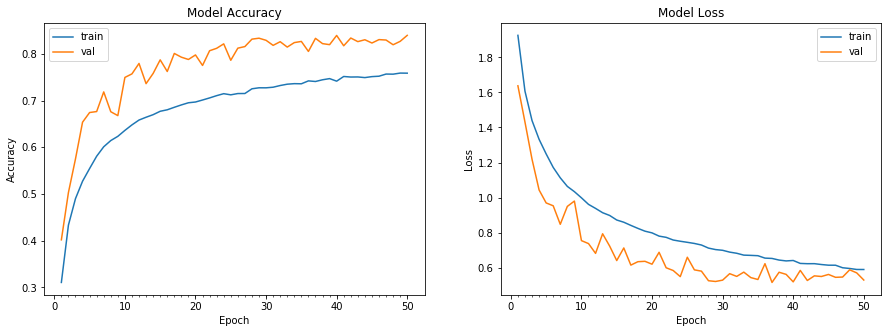

Accuracy on test data is: 83.94


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy

print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 87s 224ms/step - loss: 1.4859 - acc: 0.4862 - val_loss: 1.4448 - val_acc: 0.4959
Epoch 2/50
390/390 [==============================] - 71s 181ms/step - loss: 1.1146 - acc: 0.6252 - val_loss: 1.0316 - val_acc: 0.6541
Epoch 3/50
390/390 [==============================] - 71s 181ms/step - loss: 0.9618 - acc: 0.6752 - val_loss: 0.8578 - val_acc: 0.7234
Epoch 4/50
390/390 [==============================] - 71s 181ms/step - loss: 0.8594 - acc: 0.7083 - val_loss: 0.8119 - val_acc: 0.7365
Epoch 5/50
390/390 [==============================] - 70s 181ms/step - loss: 0.7872 - acc: 0.7291 - val_loss: 0.8003 - val_acc: 0.7391
Epoch 6/50
390/390 [==============================] - 71s 181ms/step - loss: 0.7186 - acc: 0.7525 - val_loss: 0.7481 - val_acc: 0.7515
Epoch 7/50
390/390 [==============================] - 70s 180ms/step - loss: 0.6669 - acc: 0.7717 - val_loss: 0.7645 - val_acc: 0.7507
Epoch 8/50
390/390 [==============================] - 7

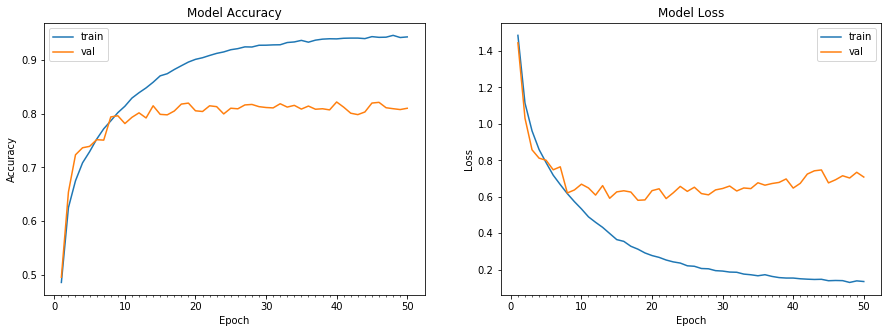

Accuracy on test data is: 80.99


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy

print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))